In [17]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import Counter
import pandas as pd





# ====================== تنظیمات ======================
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMAGE_SIZE = 64
CENTER_CROP_SIZE = 178
BATCH_SIZE = 512
NUM_WORKERS = 4
RANDOM_SEED = 42
OUTPUT_DIR = '/kaggle/working'

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"🖥️  Device: {DEVICE}")
print(f"🖼️  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"📦  Batch size: {BATCH_SIZE}")

# ====================== مسیرها ======================
CELEBA_BASE = '/kaggle/input/celeba-dataset'
ATTR_FILE = os.path.join(CELEBA_BASE, 'list_attr_celeba.csv')

# تشخیص خودکار مسیر تصاویر (یک یا دو سطح پوشه)
img_candidate_1 = os.path.join(CELEBA_BASE, 'img_align_celeba', 'img_align_celeba')
img_candidate_2 = os.path.join(CELEBA_BASE, 'img_align_celeba')

if os.path.isdir(img_candidate_1):
    # بررسی اینکه آیا واقعاً تصویر در این مسیر هست
    sample_files = os.listdir(img_candidate_1)[:5]
    if any(f.endswith('.jpg') for f in sample_files):
        IMG_DIR = img_candidate_1
    else:
        IMG_DIR = img_candidate_2
elif os.path.isdir(img_candidate_2):
    IMG_DIR = img_candidate_2
else:
    raise FileNotFoundError("❌ پوشه تصاویر پیدا نشد!")

print(f"\n📂  IMG_DIR  : {IMG_DIR}")
print(f"📄  ATTR_FILE: {ATTR_FILE}")

num_images = len([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')])
print(f"🖼️  Number of images: {num_images:,}")


🖥️  Device: cuda
🖼️  Image size: 64×64
📦  Batch size: 512

📂  IMG_DIR  : /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba
📄  ATTR_FILE: /kaggle/input/celeba-dataset/list_attr_celeba.csv
🖼️  Number of images: 202,599


In [4]:
# ====================================================================
# کلاس Dataset اختصاصی CelebA
# ====================================================================

class CelebAKaggle(Dataset):
    """
    خواندن CelebA از مسیر Kaggle
    پشتیبانی از فرمت CSV
    """
    
    def __init__(self, img_dir, attr_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        # خواندن CSV
        print("⏳ Loading attributes CSV...")
        df = pd.read_csv(attr_file)
        
        self.filenames = df.iloc[:, 0].tolist()
        self.attr_names = list(df.columns[1:])
        
        # تبدیل -1 به 0
        attr_values = df.iloc[:, 1:].values.astype(np.int64)
        attr_values = np.where(attr_values == -1, 0, attr_values)
        self.attributes = torch.tensor(attr_values, dtype=torch.long)
        
        print(f"✅ Loaded: {len(self.filenames):,} images, {len(self.attr_names)} attributes")
        print(f"   Sample attributes: {self.attr_names[:5]}")
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.attributes[idx]


# ====================== Transform ======================
train_transform = transforms.Compose([
    transforms.CenterCrop(CENTER_CROP_SIZE),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ====================== بارگذاری ======================
celeba_dataset = CelebAKaggle(
    img_dir=IMG_DIR,
    attr_file=ATTR_FILE,
    transform=train_transform
)


⏳ Loading attributes CSV...
✅ Loaded: 202,599 images, 40 attributes
   Sample attributes: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald']


In [5]:
# ====================================================================
# فیلتر و توازن: Black_Hair و Brown_Hair
# ====================================================================

print("=" * 60)
print("🔍 فیلتر و توازن داده‌ها")
print("=" * 60)

attr_names = celeba_dataset.attr_names
all_attrs = celeba_dataset.attributes

# پیدا کردن ایندکس ویژگی‌ها
black_idx = attr_names.index('Black_Hair')
brown_idx = attr_names.index('Brown_Hair')
print(f"Black_Hair attribute index: {black_idx}")
print(f"Brown_Hair attribute index: {brown_idx}")

# دسته‌بندی تصاویر
only_black = []
only_brown = []
both = []

for i in range(len(celeba_dataset)):
    has_black = all_attrs[i][black_idx].item() == 1
    has_brown = all_attrs[i][brown_idx].item() == 1
    
    if has_black and has_brown:
        both.append(i)
    elif has_black:
        only_black.append(i)
    elif has_brown:
        only_brown.append(i)

print(f"\n📊 آمار قبل از توازن:")
print(f"  Only Black_Hair : {len(only_black):>8,}")
print(f"  Only Brown_Hair : {len(only_brown):>8,}")
print(f"  Both            : {len(both):>8,}")
print(f"  ─────────────────────────")
print(f"  Total relevant  : {len(only_black) + len(only_brown) + len(both):>8,}")

# محاسبه تعداد مؤثر
eff_black = only_black + both
eff_brown = only_brown + both

print(f"\n  Effective Black_Hair: {len(eff_black):,}")
print(f"  Effective Brown_Hair: {len(eff_brown):,}")

# توازن
min_count = min(len(eff_black), len(eff_brown))
print(f"  Target count (min): {min_count:,}")

sampled_black = list(np.random.choice(eff_black, size=min_count, replace=False))
sampled_brown = list(np.random.choice(eff_brown, size=min_count, replace=False))

selected_indices = sorted(list(set(sampled_black + sampled_brown)))

# لیبل‌گذاری
labels_map = {}
for idx in selected_indices:
    hb = all_attrs[idx][black_idx].item() == 1
    hr = all_attrs[idx][brown_idx].item() == 1
    if hb and hr:
        labels_map[idx] = 2   # Both
    elif hb:
        labels_map[idx] = 0   # Black
    else:
        labels_map[idx] = 1   # Brown

lc = Counter(labels_map.values())
final_black = lc.get(0, 0) + lc.get(2, 0)
final_brown = lc.get(1, 0) + lc.get(2, 0)
ratio = min(final_black, final_brown) / max(final_black, final_brown) if max(final_black, final_brown) > 0 else 0

print(f"\n📊 آمار بعد از توازن:")
print(f"  Black_Hair (0) : {lc.get(0, 0):>8,}")
print(f"  Brown_Hair (1) : {lc.get(1, 0):>8,}")
print(f"  Both       (2) : {lc.get(2, 0):>8,}")
print(f"  ─────────────────────────")
print(f"  Total selected : {len(selected_indices):>8,}")
print(f"\n  Effective Black: {final_black:,}")
print(f"  Effective Brown: {final_brown:,}")
print(f"  Balance ratio  : {ratio:.4f} ✅")


🔍 فیلتر و توازن داده‌ها
Black_Hair attribute index: 8
Brown_Hair attribute index: 11

📊 آمار قبل از توازن:
  Only Black_Hair :   47,336
  Only Brown_Hair :   40,436
  Both            :    1,136
  ─────────────────────────
  Total relevant  :   88,908

  Effective Black_Hair: 48,472
  Effective Brown_Hair: 41,572
  Target count (min): 41,572

📊 آمار بعد از توازن:
  Black_Hair (0) :   40,593
  Brown_Hair (1) :   40,436
  Both       (2) :    1,136
  ─────────────────────────
  Total selected :   82,165

  Effective Black: 41,729
  Effective Brown: 41,572
  Balance ratio  : 0.9962 ✅


In [19]:
# ====================================================================
# ساخت Dataset فیلترشده و DataLoader
# ====================================================================

class FilteredCelebA(Dataset):
    def __init__(self, base_dataset, indices, labels_map):
        self.base = base_dataset
        self.indices = indices
        self.labels_map = labels_map
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image, full_attrs = self.base[real_idx]
        label = self.labels_map[real_idx]
        return image, label


filtered_dataset = FilteredCelebA(celeba_dataset, selected_indices, labels_map)

train_loader = DataLoader(
    filtered_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if DEVICE.type == 'cuda' else False,
    drop_last=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
    prefetch_factor=2 if NUM_WORKERS > 0 else None
)

print(f"✅ Filtered Dataset : {len(filtered_dataset):,} images")
print(f"✅ DataLoader       : {len(train_loader)} batches")
print(f"✅ Batch size       : {BATCH_SIZE}")
print(f"✅ drop_last        : True")


✅ Filtered Dataset : 82,165 images
✅ DataLoader       : 160 batches
✅ Batch size       : 512
✅ drop_last        : True


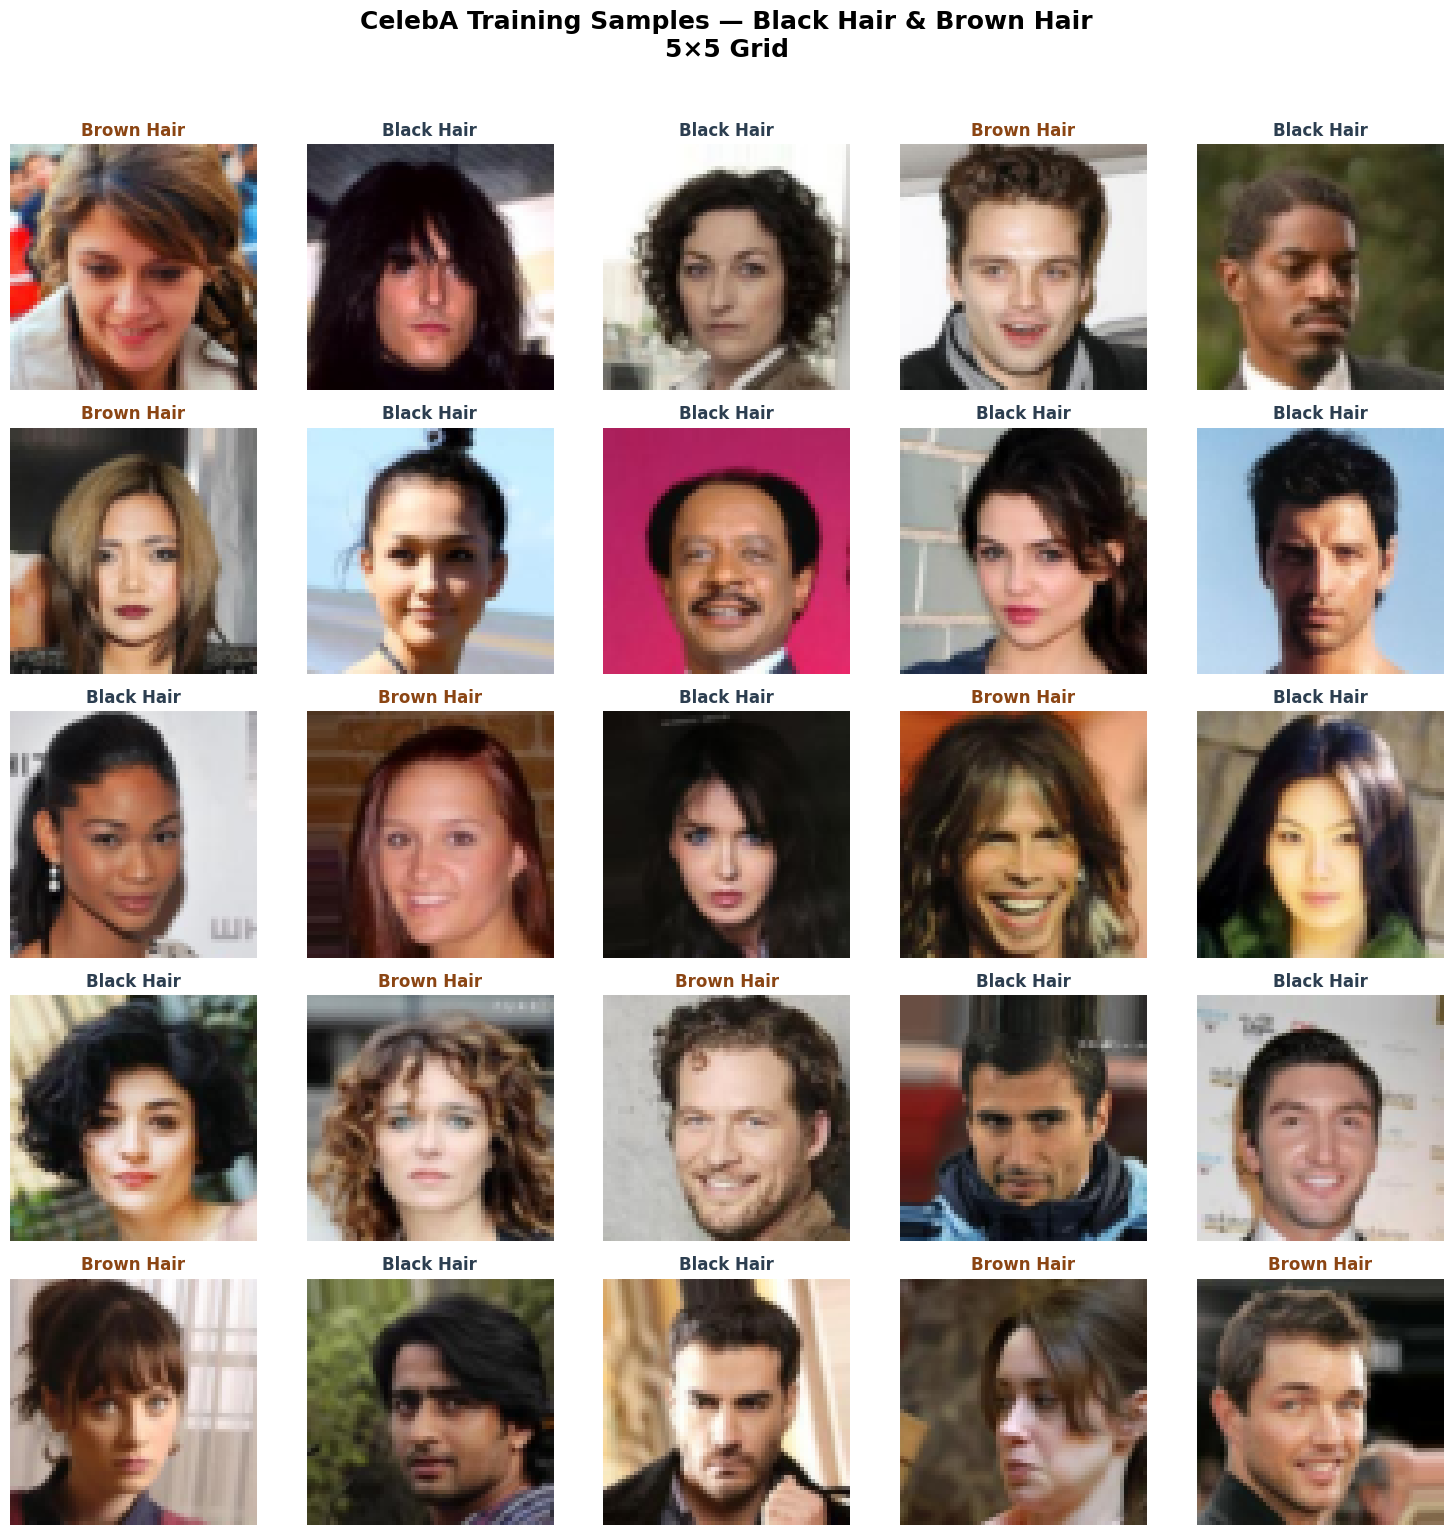

✅ Saved: /kaggle/working/celeba_grid_5x5.png


In [7]:
# ====================================================================
# نمایش گرید 5×5
# ====================================================================

def denormalize(tensor):
    """[-1, 1] → [0, 1]"""
    return tensor * 0.5 + 0.5

# گرفتن یک بچ
images, labels = next(iter(train_loader))
images_show = denormalize(images[:25])

label_names = {0: 'Black Hair', 1: 'Brown Hair', 2: 'Both'}
label_colors = {0: '#2C3E50', 1: '#8B4513', 2: '#9B59B6'}

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle('CelebA Training Samples — Black Hair & Brown Hair\n5×5 Grid',
             fontsize=18, fontweight='bold', y=1.02)

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        img = images_show[idx].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        
        lbl = labels[idx].item()
        axes[i][j].imshow(img)
        axes[i][j].set_title(label_names[lbl], fontsize=12,
                              color=label_colors[lbl], fontweight='bold')
        axes[i][j].axis('off')

plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'celeba_grid_5x5.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {save_path}")


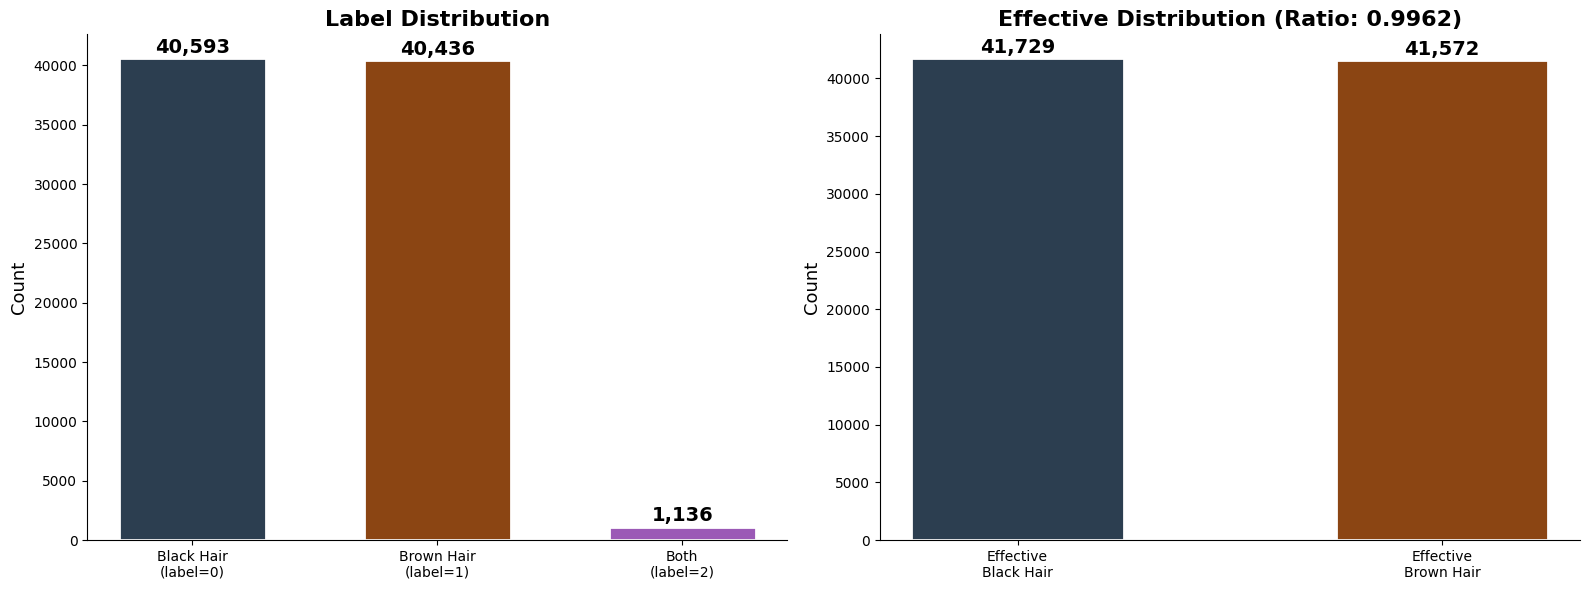

✅ Saved: /kaggle/working/label_distribution.png

📈 Pixel Statistics (first 5 batches)
  Mean (R, G, B): (0.4875, 0.4038, 0.3610)
  Std  (R, G, B): (0.3078, 0.2850, 0.2847)

📐 Image Specifications:
  Shape      : torch.Size([128, 3, 64, 64])
  Resolution : 64×64
  Channels   : 3
  Dtype      : torch.float32
  Range(norm): [-1.00, 1.00]

✅ پیش‌پردازش با موفقیت انجام شد!
   آماده برای آموزش GAN 🚀


In [8]:
# ====================================================================
# نمودار توزیع لیبل‌ها و آمار پیکسلی
# ====================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- نمودار ۱: توزیع سه‌کلاسه ---
categories = ['Black Hair\n(label=0)', 'Brown Hair\n(label=1)', 'Both\n(label=2)']
counts = [lc.get(0, 0), lc.get(1, 0), lc.get(2, 0)]
colors = ['#2C3E50', '#8B4513', '#9B59B6']

bars = axes[0].bar(categories, counts, color=colors, edgecolor='white', linewidth=2, width=0.6)
for bar, count in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
                 f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=14)
axes[0].set_title('Label Distribution', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=13)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# --- نمودار ۲: توزیع مؤثر ---
eff_cats = ['Effective\nBlack Hair', 'Effective\nBrown Hair']
eff_counts = [final_black, final_brown]
eff_colors = ['#2C3E50', '#8B4513']

bars2 = axes[1].bar(eff_cats, eff_counts, color=eff_colors, edgecolor='white', linewidth=2, width=0.5)
for bar, count in zip(bars2, eff_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
                 f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=14)
axes[1].set_title(f'Effective Distribution (Ratio: {ratio:.4f})', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=13)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
save_path = os.path.join(OUTPUT_DIR, 'label_distribution.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {save_path}")

# --- آمار پیکسلی ---
print("\n" + "=" * 60)
print("📈 Pixel Statistics (first 5 batches)")
print("=" * 60)

pixel_sum = torch.zeros(3)
pixel_sq_sum = torch.zeros(3)
total_pixels = 0

for batch_idx, (imgs, _) in enumerate(train_loader):
    if batch_idx >= 5:
        break
    imgs_dn = denormalize(imgs)
    pixel_sum += imgs_dn.sum(dim=[0, 2, 3]).cpu()
    pixel_sq_sum += (imgs_dn ** 2).sum(dim=[0, 2, 3]).cpu()
    total_pixels += imgs.shape[0] * imgs.shape[2] * imgs.shape[3]

mean = pixel_sum / total_pixels
std = torch.sqrt(pixel_sq_sum / total_pixels - mean ** 2)

print(f"  Mean (R, G, B): ({mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f})")
print(f"  Std  (R, G, B): ({std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f})")

sample_imgs, _ = next(iter(train_loader))
print(f"\n📐 Image Specifications:")
print(f"  Shape      : {sample_imgs.shape}")
print(f"  Resolution : {sample_imgs.shape[2]}×{sample_imgs.shape[3]}")
print(f"  Channels   : {sample_imgs.shape[1]}")
print(f"  Dtype      : {sample_imgs.dtype}")
print(f"  Range(norm): [{sample_imgs.min():.2f}, {sample_imgs.max():.2f}]")

print("\n" + "=" * 60)
print("✅ پیش‌پردازش با موفقیت انجام شد!")
print("   آماده برای آموزش GAN 🚀")
print("=" * 60)


# Phase 1 : 

In [14]:
# ====================================================================
# Cell 1: Configuration & Setup (LIGHTWEIGHT for Kaggle)
# ====================================================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# ====================== Reproducibility ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")  # ← اصلاح شد

# ====================== CONFIG ======================
CONFIG = {
    # --- Architecture (LIGHTWEIGHT) ---
    'nz': 100,
    'ngf': 32,
    'ndf': 32,
    'nc': 3,
    'image_size': 64,
    
    # --- Training ---
    'batch_size': 512,
    'num_epochs': 15,
    'lr_g': 0.0002,
    'lr_d': 0.0002,
    'beta1': 0.5,
    'beta2': 0.999,
    
    # --- Loss ---
    'loss_type': 'bce',
    'n_critic': 5,
    'clip_value': 0.01,
    
    # --- Eval ---
    'fid_sample_size': 1024,
    'fid_interval': 10,
    'sample_interval': 5,
    
    # --- Paths ---
    'data_dir': '/kaggle/input/celeba-dataset/img_align_celeba/',
    'save_dir': '/kaggle/working/unconditional_gan/checkpoints',
    'sample_dir': '/kaggle/working/unconditional_gan/samples',
}

# ====================== Create Dirs ======================
os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['sample_dir'], exist_ok=True)

# ====================== Dataset ======================
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(CONFIG['image_size']),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

dataset = ImageFolder(root=os.path.dirname(CONFIG['data_dir']),
                      transform=transform)

train_loader = DataLoader(
    dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

print(f"\nDataset: {len(dataset):,} images")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Image size: {CONFIG['image_size']}x{CONFIG['image_size']}")

# ====================== Fixed Noise ======================
fixed_noise = torch.randn(64, CONFIG['nz'], 1, 1, device=DEVICE)

# ====================== Quick Test ======================
test_batch = next(iter(train_loader))
print(f"\nDataLoader test: batch shape = {test_batch[0].shape}")
print(f"Value range: [{test_batch[0].min():.2f}, {test_batch[0].max():.2f}]")
print("\n✓ Setup complete!")


Device: cuda
GPU: Tesla P100-PCIE-16GB
VRAM: 17.1 GB

Dataset: 202,599 images
Batches per epoch: 395
Image size: 64x64

DataLoader test: batch shape = torch.Size([512, 3, 64, 64])
Value range: [-1.00, 1.00]

✓ Setup complete!


In [10]:
# ====================================================================
# Cell 2: Generator & Discriminator (LIGHTWEIGHT DCGAN)
# ====================================================================

def weights_init(m):
    """DCGAN weight initialization: Conv N(0,0.02), BN N(1,0.02)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    """
    Lightweight DCGAN Generator
    z (100x1x1) → 256x4x4 → 128x8x8 → 64x16x16 → 32x32x32 → 3x64x64
    
    With ngf=32:
      Layer 1: 100  → 256 (ngf*8) channels, 4x4
      Layer 2: 256  → 128 (ngf*4) channels, 8x8
      Layer 3: 128  → 64  (ngf*2) channels, 16x16
      Layer 4: 64   → 32  (ngf)   channels, 32x32
      Layer 5: 32   → 3   (nc)    channels, 64x64
    """
    
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z (nz x 1 x 1) → (ngf*8 x 4 x 4)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8 x 4 x 4) → (ngf*4 x 8 x 8)
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4 x 8 x 8) → (ngf*2 x 16 x 16)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2 x 16 x 16) → (ngf x 32 x 32)
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf x 32 x 32) → (nc x 64 x 64)
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)


class Discriminator(nn.Module):
    """
    Lightweight DCGAN Discriminator
    img (3x64x64) → 32x32x32 → 64x16x16 → 128x8x8 → 256x4x4 → 1x1x1
    """
    
    def __init__(self, nc, ndf, loss_type='bce'):
        super(Discriminator, self).__init__()
        self.loss_type = loss_type
        
        self.features = nn.Sequential(
            # (nc x 64 x 64) → (ndf x 32 x 32)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf x 32 x 32) → (ndf*2 x 16 x 16)
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2 x 16 x 16) → (ndf*4 x 8 x 8)
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4 x 8 x 8) → (ndf*8 x 4 x 4)
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.classifier = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        
        if loss_type == 'bce':
            self.output_activation = nn.Sigmoid()
        else:
            self.output_activation = nn.Identity()

    def forward(self, img):
        features = self.features(img)
        output = self.classifier(features)
        output = self.output_activation(output)
        return output.view(-1)

    def extract_features(self, img):
        """Extract features for mode collapse analysis."""
        return self.features(img).view(img.size(0), -1)


# ====================== Instantiate ======================
netG = Generator(CONFIG['nz'], CONFIG['ngf'], CONFIG['nc']).to(DEVICE)
netD = Discriminator(CONFIG['nc'], CONFIG['ndf'], CONFIG['loss_type']).to(DEVICE)

netG.apply(weights_init)
netD.apply(weights_init)

# ====================== Print Stats ======================
total_G = sum(p.numel() for p in netG.parameters())
total_D = sum(p.numel() for p in netD.parameters())

print("=" * 60)
print("  GENERATOR")
print("=" * 60)
print(netG)
print(f"\n  Parameters: {total_G:,}")

print("\n" + "=" * 60)
print("  DISCRIMINATOR")
print("=" * 60)
print(netD)
print(f"\n  Parameters: {total_D:,}")

print(f"\n{'='*60}")
print(f"  TOTAL PARAMETERS: {total_G + total_D:,}")
print(f"{'='*60}")

# ====================== Verify ======================
with torch.no_grad():
    test_z = torch.randn(2, CONFIG['nz'], 1, 1, device=DEVICE)
    test_img = netG(test_z)
    test_out = netD(test_img)

print(f"\n  Shape check:")
print(f"    z      → {test_z.shape}")
print(f"    G(z)   → {test_img.shape}")
print(f"    D(G(z))→ {test_out.shape}")
print(f"    Scores : {test_out.data.cpu().numpy()}")
print(f"\n✓ Architecture ready!")


  GENERATOR
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh

In [11]:
# ====================================================================
# Cell 3: Loss, Optimizers & FID (Optimized for Kaggle)
# ====================================================================

# ====================== Optimizers ======================
optimizerD = optim.Adam(netD.parameters(), lr=CONFIG['lr_d'],
                         betas=(CONFIG['beta1'], CONFIG['beta2']))
optimizerG = optim.Adam(netG.parameters(), lr=CONFIG['lr_g'],
                         betas=(CONFIG['beta1'], CONFIG['beta2']))

# ====================== Loss ======================
if CONFIG['loss_type'] == 'bce':
    criterion = nn.BCELoss()
    print("Loss: BCE (Standard Minimax)")
else:
    criterion = None
    print("Loss: Wasserstein")

# ====================== FID Calculator ======================
from torchvision.models import inception_v3
import torch.nn.functional as F


class FIDCalculator:
    def __init__(self, device, batch_size=64):
        self.device = device
        self.batch_size = batch_size
        self.inception = None
        self._loaded = False
    
    def _load_model(self):
        if self._loaded:
            return
        print("    Loading InceptionV3...")
        self.inception = inception_v3(weights='IMAGENET1K_V1',
                                       transform_input=False)
        self.inception.fc = nn.Identity()
        self.inception.to(self.device)
        self.inception.eval()
        self._loaded = True
    
    @torch.no_grad()
    def _get_features(self, images):
        imgs = F.interpolate(images, size=(299, 299),
                              mode='bilinear', align_corners=False)
        mean = torch.tensor([0.485, 0.456, 0.406],
                             device=self.device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225],
                            device=self.device).view(1, 3, 1, 1)
        imgs = (imgs - mean) / std
        return self.inception(imgs).cpu().numpy()
    
    @torch.no_grad()
    def compute_stats(self, dataloader, max_samples=1024):
        self._load_model()
        all_feats = []
        count = 0
        for images, _ in dataloader:
            if count >= max_samples:
                break
            images = images.to(self.device) * 0.5 + 0.5
            feats = self._get_features(images)
            all_feats.append(feats)
            count += feats.shape[0]
            if count % 256 == 0:
                print(f"    Real features: {count}/{max_samples}")
        
        all_feats = np.concatenate(all_feats)[:max_samples]
        return np.mean(all_feats, axis=0), np.cov(all_feats, rowvar=False)
    
    @torch.no_grad()
    def compute_fid(self, generator, real_mu, real_sigma, nz, num_samples=1024):
        self._load_model()
        generator.eval()
        all_feats = []
        remaining = num_samples
        
        while remaining > 0:
            batch = min(self.batch_size, remaining)
            noise = torch.randn(batch, nz, 1, 1, device=self.device)
            fake = generator(noise)
            fake = torch.clamp(fake * 0.5 + 0.5, 0, 1)
            feats = self._get_features(fake)
            all_feats.append(feats)
            remaining -= batch
        
        generator.train()
        all_feats = np.concatenate(all_feats)[:num_samples]
        gen_mu = np.mean(all_feats, axis=0)
        gen_sigma = np.cov(all_feats, rowvar=False)
        return self._frechet_dist(real_mu, real_sigma, gen_mu, gen_sigma)
    
    def unload_model(self):
        if self._loaded:
            del self.inception
            self.inception = None
            self._loaded = False
            torch.cuda.empty_cache()
            print("    InceptionV3 unloaded from GPU.")
    
    @staticmethod
    def _frechet_dist(mu1, s1, mu2, s2):
        diff = mu1 - mu2
        covmean, _ = linalg.sqrtm(s1.dot(s2), disp=False)
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        return float(diff.dot(diff) + np.trace(s1) + np.trace(s2) 
                      - 2 * np.trace(covmean))


# ====================== Compute Real Stats ======================
import time as _time

fid_calculator = FIDCalculator(DEVICE, batch_size=64)

print("\nComputing real data statistics for FID...")
_t = _time.time()
real_mu, real_sigma = fid_calculator.compute_stats(
    train_loader, max_samples=CONFIG['fid_sample_size']
)
print(f"Done in {_time.time()-_t:.1f}s | mu: {real_mu.shape}, sigma: {real_sigma.shape}")

fid_calculator.unload_model()
print("\n✓ FID setup complete! Ready for training.")


Loss: BCE (Standard Minimax)

Computing real data statistics for FID...
    Loading InceptionV3...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 223MB/s] 


    Real features: 256/1024
    Real features: 512/1024
    Real features: 768/1024
    Real features: 1024/1024
Done in 14.4s | mu: (2048,), sigma: (2048, 2048)
    InceptionV3 unloaded from GPU.

✓ FID setup complete! Ready for training.


In [12]:
# ====================================================================
# DIAGNOSTIC CELL — Run this BEFORE training
# ====================================================================
import time

print("=" * 50)
print("DIAGNOSTIC: Testing each component...")
print("=" * 50)

# --- Test 1: DataLoader ---
print("\n[1/5] Testing DataLoader...", end=" ", flush=True)
t0 = time.time()
test_batch = next(iter(train_loader))
real_imgs = test_batch[0].to(DEVICE)
print(f"OK ({time.time()-t0:.1f}s) — shape: {real_imgs.shape}")

# --- Test 2: Discriminator Forward ---
print("[2/5] Testing Discriminator forward...", end=" ", flush=True)
t0 = time.time()
with torch.no_grad():
    d_out = netD(real_imgs[:16])
print(f"OK ({time.time()-t0:.2f}s) — output: {d_out.shape}")

# --- Test 3: Generator Forward ---
print("[3/5] Testing Generator forward...", end=" ", flush=True)
t0 = time.time()
test_noise = torch.randn(16, CONFIG['nz'], 1, 1, device=DEVICE)
with torch.no_grad():
    g_out = netG(test_noise)
print(f"OK ({time.time()-t0:.2f}s) — output: {g_out.shape}")

# --- Test 4: Loss Computation ---
print("[4/5] Testing loss computation...", end=" ", flush=True)
t0 = time.time()
criterion = nn.BCELoss()
real_label = torch.full((16,), 0.9, device=DEVICE)
fake_label = torch.full((16,), 0.0, device=DEVICE)
with torch.no_grad():
    loss_r = criterion(netD(real_imgs[:16]).view(-1), real_label)
    loss_f = criterion(netD(g_out).view(-1), fake_label)
print(f"OK ({time.time()-t0:.2f}s) — D_real: {loss_r:.3f}, D_fake: {loss_f:.3f}")

# --- Test 5: One FULL Training Step ---
print("[5/5] Testing ONE full training step...", end=" ", flush=True)
t0 = time.time()

# D step
optimizerD.zero_grad()
output_real = netD(real_imgs[:16]).view(-1)
lossD_real = criterion(output_real, real_label)
lossD_real.backward()

noise = torch.randn(16, CONFIG['nz'], 1, 1, device=DEVICE)
fake = netG(noise)
output_fake = netD(fake.detach()).view(-1)
lossD_fake = criterion(output_fake, fake_label)
lossD_fake.backward()
optimizerD.step()

# G step
optimizerG.zero_grad()
output_g = netD(fake).view(-1)
lossG = criterion(output_g, torch.full((16,), 1.0, device=DEVICE))
lossG.backward()
optimizerG.step()

print(f"OK ({time.time()-t0:.2f}s)")
print(f"   D_loss: {(lossD_real+lossD_fake).item():.3f}, G_loss: {lossG.item():.3f}")

print("\n" + "=" * 50)
print("ALL TESTS PASSED ✓")
print("Training loop should work fine.")
print("=" * 50)


DIAGNOSTIC: Testing each component...

[1/5] Testing DataLoader... OK (0.9s) — shape: torch.Size([128, 3, 64, 64])
[2/5] Testing Discriminator forward... OK (0.04s) — output: torch.Size([16])
[3/5] Testing Generator forward... OK (0.11s) — output: torch.Size([16, 3, 64, 64])
[4/5] Testing loss computation... OK (0.01s) — D_real: 0.860, D_fake: 0.855
[5/5] Testing ONE full training step... OK (0.35s)
   D_loss: 1.692, G_loss: 2.340

ALL TESTS PASSED ✓
Training loop should work fine.


In [20]:
# ====================================================================
# Cell 4: Training Loop — OPTIMIZED & FIXED
# ====================================================================
import time
import sys
import torch
import os
import torchvision.utils as vutils

# ====================== Setup Lists & Constants ======================
img_list = []
G_losses = []
D_losses = []
fid_scores = []
iters = 0

print("=" * 60)
print(f"  🚀 TRAINING START — {CONFIG['num_epochs']} Epochs")
print(f"  Device: {DEVICE} | Batch Size: {CONFIG['batch_size']}")
print(f"  Images per Epoch: {len(train_loader) * CONFIG['batch_size']}")
print("=" * 60)

total_start = time.time()

for epoch in range(1, CONFIG['num_epochs'] + 1):
    epoch_start = time.time()
    
    # Switch models to train mode
    netD.train()
    netG.train()
    
    for i, data in enumerate(train_loader, 0):
        # -----------------------------------------------------------
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # -----------------------------------------------------------
        netD.zero_grad()
        
        ## A. Train with All-Real Batch
        real_cpu = data[0].to(DEVICE)
        b_size = real_cpu.size(0)
        
        # Soft labels (Label Smoothing): Real = 0.9 instead of 1.0 (Helps stability)
        label = torch.full((b_size,), 0.9, dtype=torch.float, device=DEVICE)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## B. Train with All-Fake Batch
        noise = torch.randn(b_size, CONFIG['nz'], 1, 1, device=DEVICE)
        fake = netG(noise)
        label.fill_(0.0) # Fake labels = 0
        
        # Detach fake to avoid calculating gradients for G during D update
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Combine gradients
        errD = errD_real + errD_fake
        optimizerD.step()

        # -----------------------------------------------------------
        # (2) Update G network: maximize log(D(G(z)))
        # -----------------------------------------------------------
        netG.zero_grad()
        label.fill_(1.0)  # Fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # -----------------------------------------------------------
        # (3) Logging & Memory Cleanup
        # -----------------------------------------------------------
        if i % 100 == 0:
            print(f"  [{epoch}/{CONFIG['num_epochs']}][{i}/{len(train_loader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.2f} D(G(z)): {D_G_z1:.2f}/{D_G_z2:.2f}", 
                  flush=True)
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Explicit delete to free VRAM immediately
        del real_cpu, noise, fake, output, errD_real, errD_fake, errG
        iters += 1

    # ==================== End of Epoch Actions ====================
    epoch_time = time.time() - epoch_start
    print(f"⏱️ Epoch {epoch} finished in {epoch_time:.0f}s")

    # 1. Save Sample Images
    if (epoch % CONFIG['sample_interval'] == 0) or (epoch == CONFIG['num_epochs']):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, 
                          f"{CONFIG['sample_dir']}/fake_samples_epoch_{epoch:03d}.png",
                          normalize=True, nrow=8)
        print(f"  📸 Saved sample image for epoch {epoch}")

    # 2. Compute FID (using the optimized class from Cell 3)
    if (epoch % CONFIG['fid_interval'] == 0) or (epoch == CONFIG['num_epochs']):
        print(f"  🧠 Calculating FID...", end=" ", flush=True)
        try:
            # Note: We pass 'real_mu' and 'real_sigma' computed in Cell 3
            fid_value = fid_calculator.compute_fid(
                netG, real_mu, real_sigma, CONFIG['nz'], num_samples=CONFIG['fid_sample_size']
            )
            fid_scores.append((epoch, fid_value))
            print(f"FID: {fid_value:.2f}")
            
            # Unload Inception to save memory for next epoch training
            fid_calculator.unload_model() 
            
        except Exception as e:
            print(f"Error calculating FID: {e}")

    # 3. Save Checkpoint
    if (epoch % 5 == 0) or (epoch == CONFIG['num_epochs']):
        torch.save({
            'netG': netG.state_dict(),
            'netD': netD.state_dict(),
            'optimizerG': optimizerG.state_dict(),
            'optimizerD': optimizerD.state_dict(),
            'fid_scores': fid_scores
        }, f"{CONFIG['save_dir']}/ckpt_epoch_{epoch:03d}.pth")
        print(f"  💾 Checkpoint saved.")

total_time = time.time() - total_start
print("\n" + "=" * 60)
print(f"✅ TRAINING COMPLETED in {total_time/60:.2f} minutes.")
print(f"Final FID Score: {fid_scores[-1][1] if fid_scores else 'N/A'}")
print("=" * 60)


  🚀 TRAINING START — 15 Epochs
  Device: cuda | Batch Size: 512
  Images per Epoch: 81920
  [1/15][0/160] Loss_D: 0.4964 Loss_G: 4.6539 D(x): 0.76 D(G(z)): 0.05/0.01
  [1/15][100/160] Loss_D: 0.6472 Loss_G: 3.7166 D(x): 0.80 D(G(z)): 0.21/0.03
⏱️ Epoch 1 finished in 89s
  [2/15][0/160] Loss_D: 0.5710 Loss_G: 3.3832 D(x): 0.71 D(G(z)): 0.08/0.04
  [2/15][100/160] Loss_D: 0.7283 Loss_G: 6.0882 D(x): 0.89 D(G(z)): 0.28/0.00
⏱️ Epoch 2 finished in 48s
  [3/15][0/160] Loss_D: 0.6161 Loss_G: 3.1659 D(x): 0.73 D(G(z)): 0.12/0.05
  [3/15][100/160] Loss_D: 0.5724 Loss_G: 3.0231 D(x): 0.73 D(G(z)): 0.09/0.06
⏱️ Epoch 3 finished in 48s
  [4/15][0/160] Loss_D: 0.8866 Loss_G: 0.7617 D(x): 0.50 D(G(z)): 0.02/0.57
  [4/15][100/160] Loss_D: 0.7179 Loss_G: 3.7142 D(x): 0.88 D(G(z)): 0.27/0.03
⏱️ Epoch 4 finished in 47s
  [5/15][0/160] Loss_D: 0.5892 Loss_G: 3.6246 D(x): 0.77 D(G(z)): 0.12/0.04
  [5/15][100/160] Loss_D: 1.0455 Loss_G: 1.3558 D(x): 0.43 D(G(z)): 0.06/0.30
⏱️ Epoch 5 finished in 47s
  📸 S